In [3]:
import os
import warnings
import numpy as np
import pandas as pd
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import kruskal, mannwhitneyu, kendalltau, chi2_contingency, f_oneway

In [4]:
path_dataset = '../../Dataset'
path_result = '../../Result'

path_rq12 = os.path.join(path_result, 'RQ12')
path_rq3 = os.path.join(path_result, 'RQ3')

warnings.filterwarnings('ignore')

pd.set_option("display.max_rows", None, "display.max_columns",
              None, 'display.max_colwidth', None)

tools_open_post = [
    'Domino',
    'DVC',
    'Guild AI',
    'MLflow',
    'SigOpt'
]

macro_topic_indexing = {
    0: 'Code Development',
    1: 'Code Management',
    2: 'Compute Management',
    3: 'Data Development',
    4: 'Data Management',
    5: 'Environment Management',
    6: 'Experiment Management',
    7: 'File Management',
    8: 'Model Development',
    9: 'Model Management',
    10: 'Model Deployment',
    11: 'Network Management',
    12: 'Observability Management',
    13: 'Pipeline Management',
    14: 'Security Management',
    15: 'User Interface Management'
}

stackoverflow = 'Stack Overflow'
tool = 'Tool-specific Forums'
github = 'GitHub'

color_map = {
    stackoverflow: 'rgba(50, 205, 50, 0.7)',
    github: 'rgba(255, 99, 132, 0.7)',
    tool: 'rgba(100, 149, 237, 0.7)',
}

In [5]:
def filter_open_posts(df):
    df_copy = df.copy()
    for index, row in df_copy.iterrows():
        if ('Tool' in row['Platform']) and (row['Tools'][0] in tools_open_post):
            df_copy.drop(index, inplace=True)
    return df_copy


In [6]:
df = pd.read_json(os.path.join(path_rq12, 'macro-topics.json'))
# df['Challenge_contributor_issue_ratio'] = df['Challenge_repo_contributor_count'] / df['Challenge_repo_issue_count']
# df['Challenge_watch_issue_ratio'] = df['Challenge_repo_watch_count'] / df['Challenge_repo_issue_count']

for index, row in df.iterrows():
    if 'Stack' in row['Platform']:
        df.loc[index, 'Platform'] = stackoverflow
    elif 'Tool' in row['Platform']:
        df.loc[index, 'Platform'] = tool
    elif 'GitHub Issue' in row['Platform']:
        df.loc[index, 'Platform'] = github
    else:
        df.drop(index, inplace=True)

df.to_json(os.path.join(path_rq3, 'forums.json'), orient='records', indent=4)

In [7]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))

df_platform = []
for forum_name, forum_posts in df.groupby('Platform'):
    forum_posts_filtered = filter_open_posts(forum_posts)
    info = {
        'Type': forum_name,
        'Prevalence (%)': round(len(forum_posts) / len(df) * 100, 2),
        'Unresolved rate (%)': round(forum_posts_filtered['Challenge_closed_time'].isna().sum() / len(forum_posts_filtered) * 100, 2),
        'Median resolved time (h)': round(forum_posts['Challenge_resolved_time'].median(), 2),
    }
    df_platform.append(info)

df_platform = pd.DataFrame(df_platform)
print(df_platform.to_latex(index=False, float_format="%.2f"))

\begin{tabular}{lrrr}
\toprule
Type & Prevalence (%) & Unresolved rate (%) & Median resolved time (h) \\
\midrule
GitHub & 16.87 & 30.35 & 217.51 \\
Stack Overflow & 48.82 & 67.12 & 23.74 \\
Tool-specific Forums & 34.30 & 78.32 & 13.06 \\
\bottomrule
\end{tabular}



In [13]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))

for forum_name, forum_posts in df.groupby('Platform'):
    df_inquiry = []

    for name, group in forum_posts.groupby('Challenge_type'):
        group_filtered = filter_open_posts(group)
        info = {
            'Type': name,
            'Prevalence (%)': round(len(group) / len(forum_posts) * 100, 2),
            'Unresolved rate (%)': round(group_filtered['Challenge_closed_time'].isna().sum() / len(group_filtered) * 100, 2),
            'Median resolved time (h)': round(group['Challenge_resolved_time'].median(), 2),
        }
        df_inquiry.append(info)

    df_inquiry = pd.DataFrame(df_inquiry)
    print(forum_name)
    print(df_inquiry.to_latex(index=False, float_format="%.2f"))

GitHub
\begin{tabular}{lrrr}
\toprule
Type & Prevalence (%) & Unresolved rate (%) & Median resolution time (hours) \\
\midrule
knowledge & 13.77 & 39.94 & 204.00 \\
problem & 86.23 & 28.82 & 219.88 \\
\bottomrule
\end{tabular}

Stack Overflow
\begin{tabular}{lrrr}
\toprule
Type & Prevalence (%) & Unresolved rate (%) & Median resolution time (hours) \\
\midrule
knowledge & 45.31 & 63.98 & 22.92 \\
problem & 54.69 & 69.72 & 25.36 \\
\bottomrule
\end{tabular}

Tool-specific Forums
\begin{tabular}{lrrr}
\toprule
Type & Prevalence (%) & Unresolved rate (%) & Median resolution time (hours) \\
\midrule
knowledge & 47.33 & 72.68 & 11.62 \\
problem & 52.67 & 83.18 & 14.90 \\
\bottomrule
\end{tabular}



In [8]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))

for forum_name, forum_posts in df.groupby('Platform'):
    df_inquiry = []

    for name, group in forum_posts.groupby('Challenge_topic_macro'):
        group_filtered = filter_open_posts(group)
        info = {
            'Macro-topic': macro_topic_indexing[name],
            'Prevalence (%)': round(len(group) / len(forum_posts) * 100, 2),
            'Unresolved rate (%)': round(group_filtered['Challenge_closed_time'].isna().sum() / len(group_filtered) * 100, 2),
            'Median resolved time (h)': round(group['Challenge_resolved_time'].median(), 2),
        }
        df_inquiry.append(info)

    df_inquiry = pd.DataFrame(df_inquiry)
    print(forum_name)
    df_inquiry.sort_values(by='Prevalence (%)', ascending=False, inplace=True)
    print(df_inquiry.to_latex(index=False, float_format="%.2f"))

GitHub
\begin{tabular}{lrrr}
\toprule
Macro-topic & Prevalence (%) & Unresolved rate (%) & Median resolved time (h) \\
\midrule
Environment Management & 25.63 & 29.39 & 224.90 \\
Model Management & 9.83 & 29.52 & 194.87 \\
Compute Management & 9.48 & 31.96 & 239.03 \\
Observability Management & 8.10 & 22.99 & 226.08 \\
Pipeline Management & 7.01 & 37.04 & 216.07 \\
File Management & 6.80 & 31.85 & 268.47 \\
Model Development & 6.49 & 30.67 & 295.70 \\
Data Management & 6.02 & 25.18 & 179.68 \\
Model Deployment & 5.58 & 37.98 & 211.77 \\
Experiment Management & 3.77 & 22.99 & 168.18 \\
Security Management & 3.16 & 35.62 & 164.26 \\
Code Development & 3.03 & 32.86 & 65.43 \\
Network Management & 2.29 & 32.08 & 392.32 \\
Data Development & 1.34 & 51.61 & 494.95 \\
User Interface Management & 0.95 & 13.64 & 113.55 \\
Code Management & 0.52 & 16.67 & 574.32 \\
\bottomrule
\end{tabular}

Stack Overflow
\begin{tabular}{lrrr}
\toprule
Macro-topic & Prevalence (%) & Unresolved rate (%) & Median

In [30]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
df_platform = {}

for forum_name, forum_posts in df.groupby('Platform'):
    df_inquiry = []

    for name, group in forum_posts.groupby('Challenge_topic_macro'):
        group_filtered = filter_open_posts(group)
        topic_info = {
            'Macro-topic': macro_topic_indexing[name],
            'Prevalence (%)': len(group) / len(forum_posts),
            'Unresolved rate (%)': group_filtered['Challenge_closed_time'].isna().sum() / len(group_filtered),
        }
        df_inquiry.append(topic_info)

    df_inquiry = pd.DataFrame(df_inquiry)
    df_platform[forum_name] = df_inquiry

df_final= []
keys = list(df_platform.keys())
for i in range(len(keys)):
    for j in range(i+1, len(keys)):
        key1, value1 = keys[i], df_platform[keys[i]]
        key2, value2 = keys[j], df_platform[keys[j]]
        contingency_prevalence = np.array([value1['Prevalence (%)'], value2['Prevalence (%)']])
        contingency_unresolved_rate = np.array([value1['Unresolved rate (%)'], value2['Unresolved rate (%)']])
        entry = {
            'Prevalence (%)': chi2_contingency(contingency_prevalence).pvalue,
            'Unresolved rate (%)': chi2_contingency(contingency_unresolved_rate).pvalue, 
        }
        entry = pd.Series(entry, name=f"{key1} vs {key2}")
        df_final.append(entry)
        
df_final = pd.DataFrame(df_final)
for column in df_final.columns:
    df_final[column] = fdrcorrection(df_final[column])[1]
print(df_final.to_latex(float_format="%.3f"))

\begin{tabular}{lrr}
\toprule
 & Prevalence (%) & Unresolved rate (%) \\
\midrule
GitHub vs Stack Overflow & 1.000 & 1.000 \\
GitHub vs Tool-specific Forums & 1.000 & 1.000 \\
Stack Overflow vs Tool-specific Forums & 1.000 & 1.000 \\
\bottomrule
\end{tabular}



In [10]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
df = df[df['Challenge_resolved_time'].notna()]

df_git = df[df['Platform'] == github]
df_so = df[df['Platform'] == stackoverflow]
df_tool = df[df['Platform'] == tool]

p_values = []
p_values.append(mannwhitneyu(df_git['Challenge_resolved_time'], df_so['Challenge_resolved_time'])[1])
p_values.append(mannwhitneyu(df_git['Challenge_resolved_time'], df_tool['Challenge_resolved_time'])[1])
p_values.append(mannwhitneyu(df_so['Challenge_resolved_time'], df_tool['Challenge_resolved_time'])[1])
p_values = fdrcorrection(p_values)[1]

print(f"GitHub - Stack Overflow: {p_values[0]}")
print(f"Stack Overflow - Tool-specific: {p_values[1]}")
print(f"Tool-specific - GitHub: {p_values[2]}")

GitHub - Stack Overflow: 1.003981916850287e-103
Stack Overflow - Tool-specific: 7.939132617404907e-115
Tool-specific - GitHub: 5.6130072882479476e-12


In [21]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
df = df[df['Challenge_resolved_time'].notna()]

for forum_name, forum_posts in df.groupby('Platform'):
    df_problem = forum_posts[forum_posts['Challenge_type'] == 'problem']['Challenge_resolved_time'].tolist()
    df_knowledge = forum_posts[forum_posts['Challenge_type'] == 'knowledge']['Challenge_resolved_time'].tolist()

    print(forum_name)
    print("P-value of two type of inquiries:", mannwhitneyu(df_problem, df_knowledge)[1])
    print()


GitHub
P-value of two type of inquiries: 0.820471237217124

Stack Overflow
P-value of two type of inquiries: 0.9440262256169768

Tool-specific Forums
P-value of two type of inquiries: 0.1016332564510755



In [11]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))

forum_names = []
p_values = []

for forum_name, forum_posts in df.groupby('Platform'):
    values_k = []
    values_p = []

    for index, group in forum_posts.groupby('Challenge_topic_macro'):
        group_k = group[group['Challenge_type'] == 'knowledge']
        group_p = group[group['Challenge_type'] == 'problem']
        values_k.append(len(group_k))
        values_p.append(len(group_p))
    
    contingency_table = np.array([values_k, values_p])
    forum_names.append(forum_name)
    p_values.append(chi2_contingency(contingency_table)[1])
    
p_values = fdrcorrection(p_values)[1]
for forum_name, p_value in zip(forum_names, p_values):
    print(f"{forum_name}: {p_value}")

GitHub: 0.004382025100387892
Stack Overflow: 1.4912982048522406e-12
Tool-specific Forums: 6.508502926388068e-14


In [ ]:
# df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
# # df = df[df['Challenge_resolved_time'].notna()]

# difficulty = ['Unresolved rate (%)', 'Median resolved time (h)']
# prevalence = ['Percentage (%)', 'Mean score count', 'Mean readability', 'Mean reading time (s)', 'Mean link count', 'Mean code count']
# extra_columns = {
#     'General Discussion Forum': ['Challenge_comment_count', 'Challenge_comment_readability', 'Challenge_comment_reading_time', 'Challenge_comment_link_count', 'Challenge_favorite_count', 'Challenge_view_count', 'Poster_reputation_count', 'Poster_view_count'],
#     'Repo-specific Discussion Forum': ['Challenge_comment_count', 'Challenge_comment_readability', 'Challenge_comment_reading_time', 'Challenge_comment_link_count', 'Challenge_contributor_issue_ratio', 'Challenge_repo_contributor_count', 'Challenge_repo_fork_count', 'Challenge_repo_issue_count', 'Challenge_repo_star_count', 'Challenge_repo_watch_count', 'Challenge_watch_issue_ratio'],
#     'Tool-specific Discussion Forum': [],
# }

# for forum_name, forum_posts in df.groupby('Platform'):
#     df_number = pd.DataFrame()

#     for index, group in forum_posts.groupby('Challenge_topic'):
#         entry = {
#         'Index': index + 1,
#         'Percentage (%)': round(len(group)/len(df)*100, 2),
#         'Mean score count': round(group['Challenge_score_count'].mean(), 2),
#         'Mean readability': round(group['Challenge_readability'].mean(), 2),
#         'Mean reading time (s)': round(group['Challenge_reading_time'].mean(), 2),
#         'Mean link count': round(group['Challenge_link_count'].mean(), 2),
#         'Mean code count': round(group['Challenge_code_count'].mean(), 2),
#         'Unresolved rate (%)': round(len(group[group['Challenge_resolved_time'].isna()])/len(group)*100, 2),
#         'Median resolved time (h)': round(group['Challenge_resolved_time'].median(), 2),
#         }
#         for column in extra_columns[forum_name]:
#             entry[f"Mean {' '.join(column.split('_')[1:])}"] = round(group[column].mean(), 2)
#         df_number = pd.concat([df_number, pd.DataFrame([entry])], ignore_index=True)

#     df_test = []
    
#     extra_prevalence = [f"Mean {' '.join(column.split('_')[1:])}" for column in extra_columns[forum_name]]

#     for column_d in difficulty:
#         for column_p in prevalence + extra_prevalence:
#             tau, pvalue = kendalltau(df_number[column_d], df_number[column_p])
#             kendall_tau = pd.Series({'Metrics': f'{column_d}-{column_p}', 'tau': tau, 'p-value': pvalue})
#             df_test.append(kendall_tau)
#     df_test = pd.DataFrame(df_test)
#     print(df_test.to_latex(index=False, float_format="%.3f"))

In [12]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
df = filter_open_posts(df)
df['Challenge_topic_macro'] = df['Challenge_topic_macro'].apply(lambda x: macro_topic_indexing[x])

n = len(df['Challenge_type'].unique())
fig = make_subplots(rows=n, cols=1, shared_xaxes=False, vertical_spacing=0.12)

for i, (type, type_group) in enumerate(df.groupby('Challenge_type')):
    show_legend = True if i == 0 else False
    for forum_name, forum_group in type_group.groupby('Platform'):
        categories = []
        rates = []
        
        for name, topic_group in forum_group.groupby('Challenge_topic_macro'):
            categories.append(name)
            rates.append(len(topic_group))
            
        fig.add_trace(go.Bar(
            x=categories, 
            y=rates, 
            name=forum_name, 
            showlegend=show_legend,
            marker_color=color_map[forum_name],
            text=rates, 
            textposition='outside'), 
        row=i+1, 
        col=1)
        fig.update_yaxes(title_text=f'{type[0].upper() + type[1:]} Inquiry', title_font=dict(size=20), row=i+1, col=1)

fig.update_layout(
    width=1000, 
    height=1000,
    margin=go.layout.Margin(
        l=20,  # left margin
        r=20,  # right margin
        b=20,  # bottom margin
        t=20,  # top margin
    ),
    legend_title='Inquiry type',
    boxmode='group' 
)
fig.show()
pio.full_figure_for_development(fig, warn=False)
fig.write_image(os.path.join(path_rq3, 'Macro-topics frequency histogram.pdf'), engine="kaleido")


In [13]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
df = filter_open_posts(df)
df['Challenge_topic_macro'] = df['Challenge_topic_macro'].apply(lambda x: macro_topic_indexing[x])

n = len(df['Challenge_type'].unique())
fig = make_subplots(rows=n, cols=1, shared_xaxes=False, vertical_spacing=0.12)

for i, (type, type_group) in enumerate(df.groupby('Challenge_type')):
    show_legend = True if i == 0 else False
    for forum_name, forum_group in type_group.groupby('Platform'):
        categories = []
        rates = []
        
        for name, topic_group in forum_group.groupby('Challenge_topic_macro'):
            categories.append(name)
            rates.append(round(topic_group['Challenge_closed_time'].isna().sum() / len(topic_group) * 100, 2))
            
        fig.add_trace(go.Bar(
            x=categories, 
            y=rates, 
            name=forum_name, 
            showlegend=show_legend,
            marker_color=color_map[forum_name],
            text=rates, 
            textposition='outside'), 
        row=i+1, 
        col=1)
        fig.update_yaxes(title_text=f'{type[0].upper() + type[1:]} Inquiry', title_font=dict(size=20), row=i+1, col=1)

fig.update_layout(
    width=1000, 
    height=1000,
    margin=go.layout.Margin(
        l=20,  # left margin
        r=20,  # right margin
        b=20,  # bottom margin
        t=20,  # top margin
    ),
    legend_title='Inquiry type',
    boxmode='group' 
)
fig.show()
fig.write_image(os.path.join(path_rq3, 'Macro-topics unresolved rate histogram.pdf'))


In [14]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
df = filter_open_posts(df)

forum_names = []
p_values = []

for forum_name, forum_posts in df.groupby('Platform'):
    resolved_rate_list = []

    for name, group in forum_posts.groupby('Challenge_topic_macro'):
        resolved_rate_list.append(group['Challenge_resolved_time'].isna().sum()/len(group)*100)

    contingency_table = np.array(resolved_rate_list)
    forum_names.append(forum_name)
    p_values.append(chi2_contingency(contingency_table)[1])
    
p_values = fdrcorrection(p_values)[1]
for forum_name, p_value in zip(forum_names, p_values):
    print(f"{forum_name}: {p_value}")


GitHub: 1.0
Stack Overflow: 1.0
Tool-specific Forums: 1.0


In [15]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
df = df[df['Challenge_resolved_time'].notna()]

forum_names = []
p_values_k = []
p_values_a = []

for forum_name, forum_posts in df.groupby('Platform'):
    resolved_time_list = []

    for name, group in forum_posts.groupby('Challenge_topic_macro'):
        resolved_time_list.append(group['Challenge_resolved_time'])

    forum_names.append(forum_name)
    p_values_k.append(kruskal(*resolved_time_list).pvalue)
    p_values_a.append(f_oneway(*resolved_time_list).pvalue)
    
p_values_k = fdrcorrection(p_values_k)[1]
p_values_a = fdrcorrection(p_values_a)[1]
for forum_name, p_value_k, p_value_a in zip(forum_names, p_values_k, p_values_a):
    print(forum_name)
    print(f"Kruskal-Wallis H-test: {p_value_k}")
    print(f"ANOVA: {p_value_a}")
    print()


GitHub
Kruskal-Wallis H-test: 0.38340870644494
ANOVA: 0.0024246674497083315

Stack Overflow
Kruskal-Wallis H-test: 0.006530647387262884
ANOVA: 0.6837677003760778

Tool-specific Forums
Kruskal-Wallis H-test: 0.0022522931458547864
ANOVA: 0.31639207644297046



In [16]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
df['Challenge_resolved_time'] = df['Challenge_resolved_time'].apply(lambda x: np.log(x+1))
df['Challenge_topic_macro'] = df['Challenge_topic_macro'].apply(lambda x: macro_topic_indexing[x])

n = len(df['Challenge_type'].unique())
fig = make_subplots(rows=n, cols=1, shared_xaxes=False, vertical_spacing=0.12)

for i, (type, group) in enumerate(df.groupby('Challenge_type')):
    temp_fig = px.box(group, x="Challenge_topic_macro", y="Challenge_resolved_time", color="Platform")
    for trace in temp_fig.data:       
        trace.showlegend = True if i == 0 else False
        fig.add_trace(trace, row=i+1, col=1)
    fig.update_yaxes(title_text=f'{type[0].upper() + type[1:]} Inquiry', title_font=dict(size=20), row=i+1, col=1)

fig.update_layout(
    width=1000, 
    height=1000,
    margin=go.layout.Margin(
        l=20,  # left margin
        r=20,  # right margin
        b=20,  # bottom margin
        t=20,  # top margin
    ),
    legend_title='Inquiry type',
    boxmode='group' 
)
fig.show()
fig.write_image(os.path.join(path_rq3, f'Macro-topics resolved time boxplot.pdf'))


In [17]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
df = df[df['Challenge_resolved_time'].notna()]

for forum_name, forum_posts in df.groupby('Platform'):
    df_test = []

    for macro_name, macro_group in forum_posts.groupby('Challenge_topic_macro', sort=True):
        frequency_p = []
        frequency_k = [] 
    
        for name, group in macro_group.groupby('Challenge_topic'):
            frequency_p.append(len(group[group['Challenge_type'] == 'problem']))
            frequency_k.append(len(group[group['Challenge_type'] == 'knowledge']))
        contingency_table = np.array([frequency_p, frequency_k])
        try:
            pvalue = chi2_contingency(contingency_table).pvalue
        except:
            pvalue = 1
        test = {
            'Macro-topic': macro_topic_indexing[macro_name],
            'p-value': pvalue,
        }
        df_test.append(test)

    df_test = pd.DataFrame(df_test)
    df_test['p-value'] = fdrcorrection(df_test['p-value'])[1]
    print('Table Name:', forum_name)
    print(df_test.to_latex(index=False, float_format="%.3f"))


Table Name: GitHub
\begin{tabular}{lr}
\toprule
Macro-topic & p-value \\
\midrule
Code Development & 0.883 \\
Code Management & 1.000 \\
Compute Management & 0.155 \\
Data Development & 1.000 \\
Data Management & 0.734 \\
Environment Management & 0.207 \\
Experiment Management & 1.000 \\
File Management & 0.883 \\
Model Development & 0.589 \\
Model Management & 0.589 \\
Model Deployment & 0.883 \\
Network Management & 0.384 \\
Observability Management & 1.000 \\
Pipeline Management & 0.407 \\
Security Management & 0.104 \\
User Interface Management & 1.000 \\
\bottomrule
\end{tabular}

Table Name: Stack Overflow
\begin{tabular}{lr}
\toprule
Macro-topic & p-value \\
\midrule
Code Development & 0.274 \\
Code Management & 1.000 \\
Compute Management & 0.274 \\
Data Development & 0.153 \\
Data Management & 0.012 \\
Environment Management & 0.006 \\
Experiment Management & 0.687 \\
File Management & 0.583 \\
Model Development & 0.861 \\
Model Management & 0.274 \\
Model Deployment & 0.321 \

In [18]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
df = filter_open_posts(df)

forum_names = []
p_values = []

for forum_name, forum_posts in df.groupby('Platform'):
    values_k = []
    values_p = []

    for index, group in forum_posts.groupby('Challenge_topic_macro'):
        group_k = group[group['Challenge_type'] == 'knowledge']
        group_p = group[group['Challenge_type'] == 'problem']
        values_k.append(group_k['Challenge_resolved_time'].isna().sum()/len(group_k)*100)
        values_p.append(group_p['Challenge_resolved_time'].isna().sum()/len(group_p)*100)

    contingency_table = np.array([values_k, values_p])
    forum_names.append(forum_name)
    p_values.append(chi2_contingency(contingency_table)[1])
    
p_values = fdrcorrection(p_values)[1]
for forum_name, p_value in zip(forum_names, p_values):
    print(f"{forum_name}: {p_value}")

GitHub: 6.6123605534438986e-06
Stack Overflow: 0.9905408797564365
Tool-specific Forums: 0.9905408797564365


In [19]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
df = df[df['Challenge_resolved_time'].notna()]

for forum_name, forum_posts in df.groupby('Platform'):
    df_test = []

    for index, group in forum_posts.groupby('Challenge_topic_macro'):
        group_k = group[group['Challenge_type'] == 'knowledge']
        group_p = group[group['Challenge_type'] == 'problem']
        try:
            p_value = mannwhitneyu(group_k['Challenge_resolved_time'], group_p['Challenge_resolved_time']).pvalue
        except:
            p_value = 1
        test = {
            'Macro-topic': macro_topic_indexing[index],
            'p-value': p_value,
        }
        df_test.append(test)

    df_test = pd.DataFrame(df_test)
    df_test['p-value'] = fdrcorrection(df_test['p-value'])[1]
    print(forum_name)
    print(df_test.to_latex(index=False, float_format="%.3f"))


GitHub
\begin{tabular}{lr}
\toprule
Macro-topic & p-value \\
\midrule
Code Development & 0.995 \\
Code Management & 1.000 \\
Compute Management & 0.995 \\
Data Development & 0.141 \\
Data Management & 0.995 \\
Environment Management & 0.959 \\
Experiment Management & 0.141 \\
File Management & 0.995 \\
Model Development & 0.959 \\
Model Management & 0.959 \\
Model Deployment & 0.995 \\
Network Management & 0.995 \\
Observability Management & 0.995 \\
Pipeline Management & 0.995 \\
Security Management & 0.995 \\
User Interface Management & 0.995 \\
\bottomrule
\end{tabular}

Stack Overflow
\begin{tabular}{lr}
\toprule
Macro-topic & p-value \\
\midrule
Code Development & 1.000 \\
Code Management & 0.771 \\
Compute Management & 0.955 \\
Data Development & 0.771 \\
Data Management & 1.000 \\
Environment Management & 1.000 \\
Experiment Management & 1.000 \\
File Management & 1.000 \\
Model Development & 0.771 \\
Model Management & 0.815 \\
Model Deployment & 1.000 \\
Network Management & 1

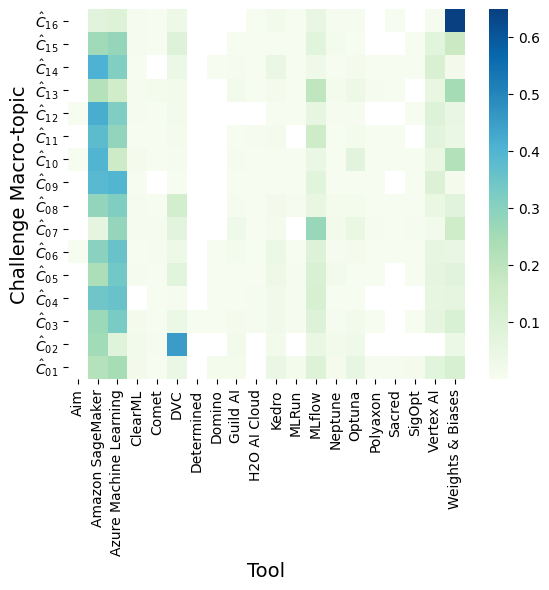

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_json(os.path.join(path_rq12, 'macro-topics.json'))
df['Challenge_topic_macro'] = df['Challenge_topic_macro'].apply(lambda x: r'$\hat{C}_{0' + str(x+1) + '}$' if x < 9 else r'$\hat{C}_{' + str(x+1) + '}$')
df = df.explode('Tools')

df_statistics = df[['Tools', 'Challenge_topic_macro']].value_counts().reset_index(name='count')
df_grouped = df_statistics.groupby('Challenge_topic_macro')['count'].sum().reset_index()
df_grouped.rename(columns={'count': 'sum'}, inplace=True)
df_merged = pd.merge(df_statistics, df_grouped, on='Challenge_topic_macro')
df_merged['normalized_count'] = df_merged['count'] / df_merged['sum']

df_heatmap = df_merged.pivot_table(values='normalized_count', index='Challenge_topic_macro', columns='Tools', aggfunc=np.mean)
ax = sns.heatmap(df_heatmap, cmap="GnBu")
ax.invert_yaxis()
ax.set_xlabel('Tool', fontsize=14)
ax.set_ylabel('Challenge Macro-topic', fontsize=14)
# plt.savefig(os.path.join(path_rq4, f'{type}_resolution_heatmap_macro.pdf'), bbox_inches='tight')
plt.show()